In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [8]:
!pip install --upgrade pip

In [11]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-_lb5jkup
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-_lb5jkup
  Resolved https://github.com/tensorflow/docs to commit 5b96ef6e94e6db28f4a4becdaade2afac558c437
  Preparing metadata (setup.py) ... - done


In [13]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [14]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [15]:
logdir = pathlib.Path(tempfile.mktemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [17]:
#zbiór danych Higgsa
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 272s 0us/step


In [18]:
FEATURES = 28

In [19]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type="GZIP")

In [20]:
def pack_row(*row):
    label=row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [21]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


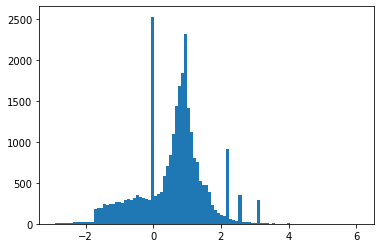

In [22]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(),bins=101)

In [23]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [24]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [25]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [26]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [27]:
#procedura szkolenia
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

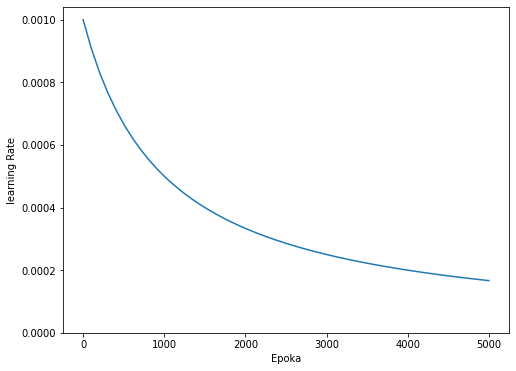

In [28]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoka')
_ = plt.ylabel('learning Rate')

In [29]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [33]:
def compile_and_fit(model,name,optimizer=None,max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(
                          from_logits=True,name='binary_crossentropy'),
                          'accuracy'
                      
                  ])
    model.summary()
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    return history

In [34]:
#bardzo mały model
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [32]:
size_histories = {}

In [35]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4827,  binary_crossentropy:0.8338,  loss:0.8338,  val_accuracy:0.4900,  val_binary_crossentropy:0.7448,  val_loss:0.7448,  
....................................................................................................
Epoch: 100, accuracy:0.5975,  binary_crossentropy:0.6287,  loss:0.6287,  val_accuracy:0.5510,  val_binary_crossentropy:0.6401,  val_loss:0.6401,  
..........................................................

(0.5, 0.7)

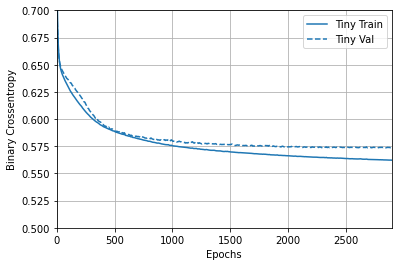

In [36]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std =10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])